# Essentials of using the Science Pipelines

## Topics to cover

---

- Middleware (aka the Butler)
- Data model and using data products
- Pipelines, PipelineTasks, and Execution

## Middleware
A system for mediating data storage, query, and retrieval.

You don't need to know if your data is stored on a file system, s3, or retrieved from a database somewhere. You can get what you need by knowing intrinsic properties about your data rather than extrinsic information.

- User: Why not use folders and FITS files?
- Middleware: For one there are too many files for a simple directory system.
- User: OK, I'll get cleaver and shard them by parameters.
- Middleware: How will users know how to find what they are looking for?
- User: I'll just add an index.
- Middleware: How will you handle relating the data to each other?
- User: I'll add metadata about the files.
- Middleware: Congratulations, you're on your way to making your own middleware!

## Concepts
* Butler - The main API interface for the middleware
* Registry - A sub-component of the butler used to query various metadata
* Repo - One instantiation of the middleware backend
* Dimension - A unique thing that can be used to identify data, sort of like a key in a mapping
* DataID - A unique combination of dimension values (like a location)
* Dataset - A bit of data is the the product of running an algorithm (overloaded term)
* DatasetType - A conceptual data product that is the result of a specific processing of input data
* DatasetRef - A DatasetType and a DataID bundled together that describe loading a specific piece of data
* StorageClass - A class which describes how a Dataset is written out and read in. Multiple DatasetTypes can use the same StorageClass
* PipelineTasks - A data processing algorithm which fully declares its inputs, outputs, and units of work
* Collections - A grouping of processed data, A given `DatasetType` and `DataId` combination are unique within a collection.
* Pipeline - A document which declares a set of PipelineTasks along with configuration overrides needed to process specific data

More specific documentation on these topics can be found [here](https://pipelines.lsst.io/modules/lsst.daf.butler/index.html) and [here](https://pipelines.lsst.io/modules/lsst.pipe.base/index.html).

## Practical use

In [10]:
# A repo which exists at the USDF, contains data from various instruments and
REPO = '/repo/main'

from lsst.daf.butler import Butler
from pprint import pprint

# Here we specify a default collection to use
butler = Butler(REPO, collections="HSC/runs/RC2/w_2023_15/DM-38691")

We can look at all the collections stored within this Repo by querying the registry.

In [11]:
butler.registry.queryCollections()

['skymaps',
 'HSC/raw/all',
 'HSC/calib/DM-28636',
 'HSC/calib/DM-28636/unbounded',
 'HSC/calib/DM-28636/curated/19700101T000000Z',
 'HSC/calib/DM-28636/curated/20130131T000000Z',
 'HSC/calib/DM-28636/curated/20140403T000000Z',
 'HSC/calib/DM-28636/curated/20140601T000000Z',
 'HSC/calib/DM-28636/curated/20151106T000000Z',
 'HSC/calib/DM-28636/curated/20160401T000000Z',
 'HSC/calib/DM-28636/curated/20161122T000000Z',
 'HSC/calib/DM-28636/curated/20161223T000000Z',
 'refcats/DM-28636',
 'HSC/runs/RC2/w_2021_14/DM-29519/sfm',
 'HSC/runs/RC2/w_2021_14/DM-29519/rest',
 'HSC/runs/RC2/w_2021_14/DM-29519',
 'u/plazas/postISR.1',
 'u/plazas/postISR.1/20210416T193607Z',
 'HSC/raw/RC2/9615',
 'HSC/raw/RC2/9697',
 'u/kbechtol/calib_test/20210426T202234Z',
 'HSC/raw/RC2',
 'HSC/calib/unbounded',
 'LATISS/raw/all',
 'LSSTComCam/raw/CCS-C',
 'u/lauren/DM-29326cpVig/20210331T004847Z',
 'u/lauren/DM-29326cpVig/20210331T015132Z',
 'HSC/runs/RC2/w_2021_14/DM-29528',
 'HSC/runs/RC2/w_2021_14/DM-29528/2021

As you can see, there are lots of collections. Don't really be worried about putting things in it. It exists to be used.

Lets say we are looking for some metrics outputs, but we don't quite know what the name is. We can start by looking at all the dataset types the butler knows about:

In [12]:
butler.registry.queryDatasetTypes()

[DatasetType('skyMap', {skymap}, SkyMap),
 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure),
 DatasetType('camera', {instrument}, Camera, isCalibration=True),
 DatasetType('defects', {instrument, detector}, Defects, isCalibration=True),
 DatasetType('bfKernel', {instrument}, NumpyArray, isCalibration=True),
 DatasetType('transmission_optics', {instrument}, TransmissionCurve, isCalibration=True),
 DatasetType('transmission_sensor', {instrument, detector}, TransmissionCurve, isCalibration=True),
 DatasetType('transmission_filter', {band, instrument, physical_filter}, TransmissionCurve, isCalibration=True),
 DatasetType('transmission_atmosphere', {instrument}, TransmissionCurve, isCalibration=True),
 DatasetType('sky', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True),
 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True),
 DatasetType('flat', {band, instrument, detector, physical_filter}, ExposureF, is

Thats a lot of datasets, and not a problem for the butler to manage. In this case we know that we are looking for something of the form `*_metrics`

In [13]:
metricsList = list(butler.registry.queryDatasetTypes('*_metrics'))
# Note: please ignore the Spectractor WARNING messages below, they are to be expected here.

In [14]:
print(metricsList)
for metric in metricsList:
    print(metric)

[DatasetType('objectTable_tract_metrics', {skymap, tract}, MetricMeasurementBundle), DatasetType('sourceTable_visit_metrics', {band, instrument, physical_filter, visit}, MetricMeasurementBundle), DatasetType('objectTable_tract_astrometryRefCat_match_metrics', {skymap, tract}, MetricMeasurementBundle), DatasetType('sourceTable_visit_astrometryRefCat_match_metrics', {band, instrument, skymap, physical_filter, visit}, MetricMeasurementBundle), DatasetType('objectTable_tract_gaia_dr2_20200414_match_metrics', {skymap, tract}, MetricMeasurementBundle), DatasetType('sourceTableCore_metrics', {band, instrument, physical_filter, visit}, MetricMeasurementBundle), DatasetType('sourceTable_visit_gaia_dr2_20200414_match_metrics', {band, instrument, physical_filter, visit}, MetricMeasurementBundle), DatasetType('objectTableCore_metrics', {skymap, tract}, MetricMeasurementBundle), DatasetType('visitTableCore_metrics', {band, instrument, physical_filter, visit}, MetricMeasurementBundle), DatasetType('

Lets look at `objectTable_tract_metrics`, here we search for that position to guard against ordering changes

In [15]:
for metric in metricsList:
    if 'objectTableCore' in metric.name:
        break
print(metric)

DatasetType('objectTableCore_metrics', {skymap, tract}, MetricMeasurementBundle)


This is an instance of the python class corresponding to `DatasetType`.

The first thing you notice is the name of the dataset type. The second thing you see is a set of Dimensions. This says that each dataset with the DatasetType `objectTableCore_metrics` will correspond to a given tract defined within a given skymap. Said another way if you provide a tract number defined by some skymap, you will be able to get one dataset of the type `objectTableCore_metrics`. Each tract will have its own unique dataset.

The final thing you see is the storage class. This is a representation of how the dataset is stored on disk. Multiple dataset types can use the same storage class, as is the case with things like raws, and calexps both using the Exposure StorageClass.

Now that we have the description of the DatasetType, let's find all the concrete dataset refs within our collection that correspond to that dataset type.

In [16]:
refs = set(butler.registry.queryDatasets(metric))
for ref in refs:
    print(ref)


objectTableCore_metrics@{skymap: 'hsc_rings_v1', tract: 9813}, sc=MetricMeasurementBundle] (id=03885b81-fba1-49b0-99f6-69d2dab1b9e6)
objectTableCore_metrics@{skymap: 'hsc_rings_v1', tract: 9615}, sc=MetricMeasurementBundle] (id=3f9de916-4592-4a21-ab4b-814e61346f8c)
objectTableCore_metrics@{skymap: 'hsc_rings_v1', tract: 9697}, sc=MetricMeasurementBundle] (id=ea60eecb-8391-4686-8341-2f3e094e2992)


In [23]:
print(ref)

objectTableCore_metrics@{skymap: 'hsc_rings_v1', tract: 9697}, sc=MetricMeasurementBundle] (id=ea60eecb-8391-4686-8341-2f3e094e2992)


Here we can see the `DatasetRefs` found by the butler in the collection we specified. These refs begin with the `DatasetType` we were looking for. Next, you can see the `DatasetID`. This contains the concrete values for each dimension defined in the `DatasetType`. The ref also shows the `StorageClass`, as well as an id parameter. This id is globally unique across all datasets in any collection within the repository.

Now that we have a dataset ref, lets use the butler to fetch the data it is referring to.

In [18]:
bundle = butler.get(ref)
pprint(bundle)

{'e1DiffScatterMetric': [Measurement('g_highSNStars_median', <Quantity 0.0088477 pix>),
                         Measurement('g_highSNStars_sigmaMad', <Quantity 0.01263271 pix>),
                         Measurement('g_highSNStars_count', <Quantity 28. ct>),
                         Measurement('g_lowSNStars_median', <Quantity 0.00013339 pix>),
                         Measurement('g_lowSNStars_sigmaMad', <Quantity 0.00471124 pix>),
                         Measurement('g_lowSNStars_count', <Quantity 3439. ct>),
                         Measurement('r_highSNStars_median', <Quantity 0.0025652 pix>),
                         Measurement('r_highSNStars_sigmaMad', <Quantity 0.00391875 pix>),
                         Measurement('r_highSNStars_count', <Quantity 8. ct>),
                         Measurement('r_lowSNStars_median', <Quantity 0.00054198 pix>),
                         Measurement('r_lowSNStars_sigmaMad', <Quantity 0.00466681 pix>),
                         Measurement('r_lowSNS

If the `DatasetType` name and `DataId` are known ahead of time, you can ask the butler to fetch the dataset without doing any of the queries above.

In [19]:
bundle2 = butler.get('objectTableCore_metrics', {'skymap': 'hsc_rings_v1', 'tract': 9697})
pprint(bundle2)

{'e1DiffScatterMetric': [Measurement('g_highSNStars_median', <Quantity 0.0088477 pix>),
                         Measurement('g_highSNStars_sigmaMad', <Quantity 0.01263271 pix>),
                         Measurement('g_highSNStars_count', <Quantity 28. ct>),
                         Measurement('g_lowSNStars_median', <Quantity 0.00013339 pix>),
                         Measurement('g_lowSNStars_sigmaMad', <Quantity 0.00471124 pix>),
                         Measurement('g_lowSNStars_count', <Quantity 3439. ct>),
                         Measurement('r_highSNStars_median', <Quantity 0.0025652 pix>),
                         Measurement('r_highSNStars_sigmaMad', <Quantity 0.00391875 pix>),
                         Measurement('r_highSNStars_count', <Quantity 8. ct>),
                         Measurement('r_lowSNStars_median', <Quantity 0.00054198 pix>),
                         Measurement('r_lowSNStars_sigmaMad', <Quantity 0.00466681 pix>),
                         Measurement('r_lowSNS

Say we learned some info above, and were curious about what visits overlapped tract 9697 from the `DataId` of the above metrics. We can ask the butler for just such information:

In [20]:
results = set(butler.registry.queryDataIds('visit', dataId={"tract":9697, "skymap":"hsc_rings_v1"}))
pprint(results)

{{instrument: 'HSC', visit: 6320, ...},
 {instrument: 'HSC', visit: 7138, ...},
 {instrument: 'HSC', visit: 34336, ...},
 {instrument: 'HSC', visit: 34338, ...},
 {instrument: 'HSC', visit: 34340, ...},
 {instrument: 'HSC', visit: 34342, ...},
 {instrument: 'HSC', visit: 34356, ...},
 {instrument: 'HSC', visit: 34358, ...},
 {instrument: 'HSC', visit: 34360, ...},
 {instrument: 'HSC', visit: 34362, ...},
 {instrument: 'HSC', visit: 34364, ...},
 {instrument: 'HSC', visit: 34366, ...},
 {instrument: 'HSC', visit: 34382, ...},
 {instrument: 'HSC', visit: 34384, ...},
 {instrument: 'HSC', visit: 34400, ...},
 {instrument: 'HSC', visit: 34402, ...},
 {instrument: 'HSC', visit: 34412, ...},
 {instrument: 'HSC', visit: 34414, ...},
 {instrument: 'HSC', visit: 34416, ...},
 {instrument: 'HSC', visit: 34422, ...},
 {instrument: 'HSC', visit: 34424, ...},
 {instrument: 'HSC', visit: 34436, ...},
 {instrument: 'HSC', visit: 34438, ...},
 {instrument: 'HSC', visit: 34448, ...},
 {instrument: 'HSC

If we were interested in fetching some data we could do that a bit more directly. Perhaps we are interested in I band data overlapping our tract for detectors 20 through 22 on any visit. The corresponding butler command would be:

In [21]:
visit_dataIds = set(butler.registry.queryDataIds(["visit", "detector"],
                                                  where="tract=9697 and band='i' and detector in (20..22)",
                                                  skymap="hsc_rings_v1"))
pprint(visit_dataIds)

{{instrument: 'HSC', detector: 20, visit: 35892, ...},
 {instrument: 'HSC', detector: 20, visit: 36138, ...},
 {instrument: 'HSC', detector: 20, visit: 36140, ...},
 {instrument: 'HSC', detector: 20, visit: 36142, ...},
 {instrument: 'HSC', detector: 20, visit: 36144, ...},
 {instrument: 'HSC', detector: 20, visit: 36146, ...},
 {instrument: 'HSC', detector: 20, visit: 36148, ...},
 {instrument: 'HSC', detector: 20, visit: 36170, ...},
 {instrument: 'HSC', detector: 20, visit: 36192, ...},
 {instrument: 'HSC', detector: 20, visit: 36212, ...},
 {instrument: 'HSC', detector: 20, visit: 36214, ...},
 {instrument: 'HSC', detector: 20, visit: 36218, ...},
 {instrument: 'HSC', detector: 20, visit: 36240, ...},
 {instrument: 'HSC', detector: 20, visit: 36258, ...},
 {instrument: 'HSC', detector: 20, visit: 36260, ...},
 {instrument: 'HSC', detector: 21, visit: 36138, ...},
 {instrument: 'HSC', detector: 21, visit: 36140, ...},
 {instrument: 'HSC', detector: 21, visit: 36142, ...},
 {instrume

Note that the results are not actually datasets, or even refs to them, they are just dataIds known to the butler. There may or may not be any data actually at the `DataId` coordinates. We can further narrow this to only include `DataIds` which are populated with particular datasets:

In [22]:
visit_dataIds = set(butler.registry.queryDataIds(["visit", "detector"],
                                                 where="tract=9697 and band='i' and detector in (20..22)",
                                                 skymap="hsc_rings_v1",
                                                 datasets='calexp'))
pprint(visit_dataIds)

{{instrument: 'HSC', detector: 20, visit: 35892, ...},
 {instrument: 'HSC', detector: 20, visit: 36140, ...},
 {instrument: 'HSC', detector: 20, visit: 36144, ...},
 {instrument: 'HSC', detector: 20, visit: 36148, ...},
 {instrument: 'HSC', detector: 20, visit: 36170, ...},
 {instrument: 'HSC', detector: 20, visit: 36192, ...},
 {instrument: 'HSC', detector: 20, visit: 36212, ...},
 {instrument: 'HSC', detector: 20, visit: 36214, ...},
 {instrument: 'HSC', detector: 20, visit: 36218, ...},
 {instrument: 'HSC', detector: 20, visit: 36240, ...},
 {instrument: 'HSC', detector: 20, visit: 36258, ...},
 {instrument: 'HSC', detector: 20, visit: 36260, ...},
 {instrument: 'HSC', detector: 21, visit: 36140, ...},
 {instrument: 'HSC', detector: 21, visit: 36144, ...},
 {instrument: 'HSC', detector: 21, visit: 36148, ...},
 {instrument: 'HSC', detector: 21, visit: 36170, ...},
 {instrument: 'HSC', detector: 21, visit: 36190, ...},
 {instrument: 'HSC', detector: 21, visit: 36192, ...},
 {instrume

We could have done the same as in the command above, but instead call `queryDatasets` if we wanted to get `DatasetRefs` directly to the data.

## Tasks and PipelineTasks

* Data processing is done with algorithms called Tasks
* Basic tasks take/return in memory data products from/to other Tasks, PipelineTasks take/return data from/to the middleware system which is ultimately IO through the butler.

All tasks:
* Are a single logical algorithm to do one job
* Composable, Tasks can contain other Tasks within them.
* Have a schema for configuration (ConfigClass) that is separately defined and persistable.

Pipeline Tasks:
* Declare an interface of “connections”, Inputs / outputs with the dataset types, their dimensions (for substitution) and storage class (for polymorphism)
* Dimensions the task will operate on, this defines how inputs will be grouped. I.e. one task takes all detectors at one time, where another might operate on detectors one at a time. This runtime grouping of inputs and outputs is know as a Quantum

## Pipelines

* PipelineTasks that are to be run together, alongside their configuration, are labeled and grouped into a Pipeline, written declaratively in YAML.
* Labels allow for a task to be used multiple times within one pipeline with different configurations.
* Tasks within a Pipeline file need not be ordered, the execution order determined automatically from each task’s connections.
* Pipelines are designed for a purpose, the same tasks may be in different pipelines with different configs for different reasons.
* Support named subsets for processing parts of a pipeline

### Example Pipeline
```yaml
description: A demo pipeline in the how-to guide
tasks:
  isr:
    class: lsst.ip.isr.IsrTask
    config:
      doVignette: true
      vignetteValue: 0.0
  characterizeImage: lsst.pipe.tasks.characterizeImage.CharacterizeImageTask
  calibrate:
    class: lsst.pipe.tasks.calibrate.CalibrateTask
    config:
      astrometry.matcher.maxOffsetPix: 300
```

* Take the simple declaration of tasks from a Pipeline, examine the connections of each (in context of their config which may modify connections)
* Organize the tasks into a Directed Acyclic Graph, in execution dependency order
* Individual Task authors need not know anything about this structure, which in general will be different for different pipelines.
* This allows authors to work in a system akin to familiar software development practices where they need only be concerned with APIs rather than overall complexity.

This is a part of the DRP processing pipeline, specialized for the RC2 subset.
<div style="width: 1000px;">
    
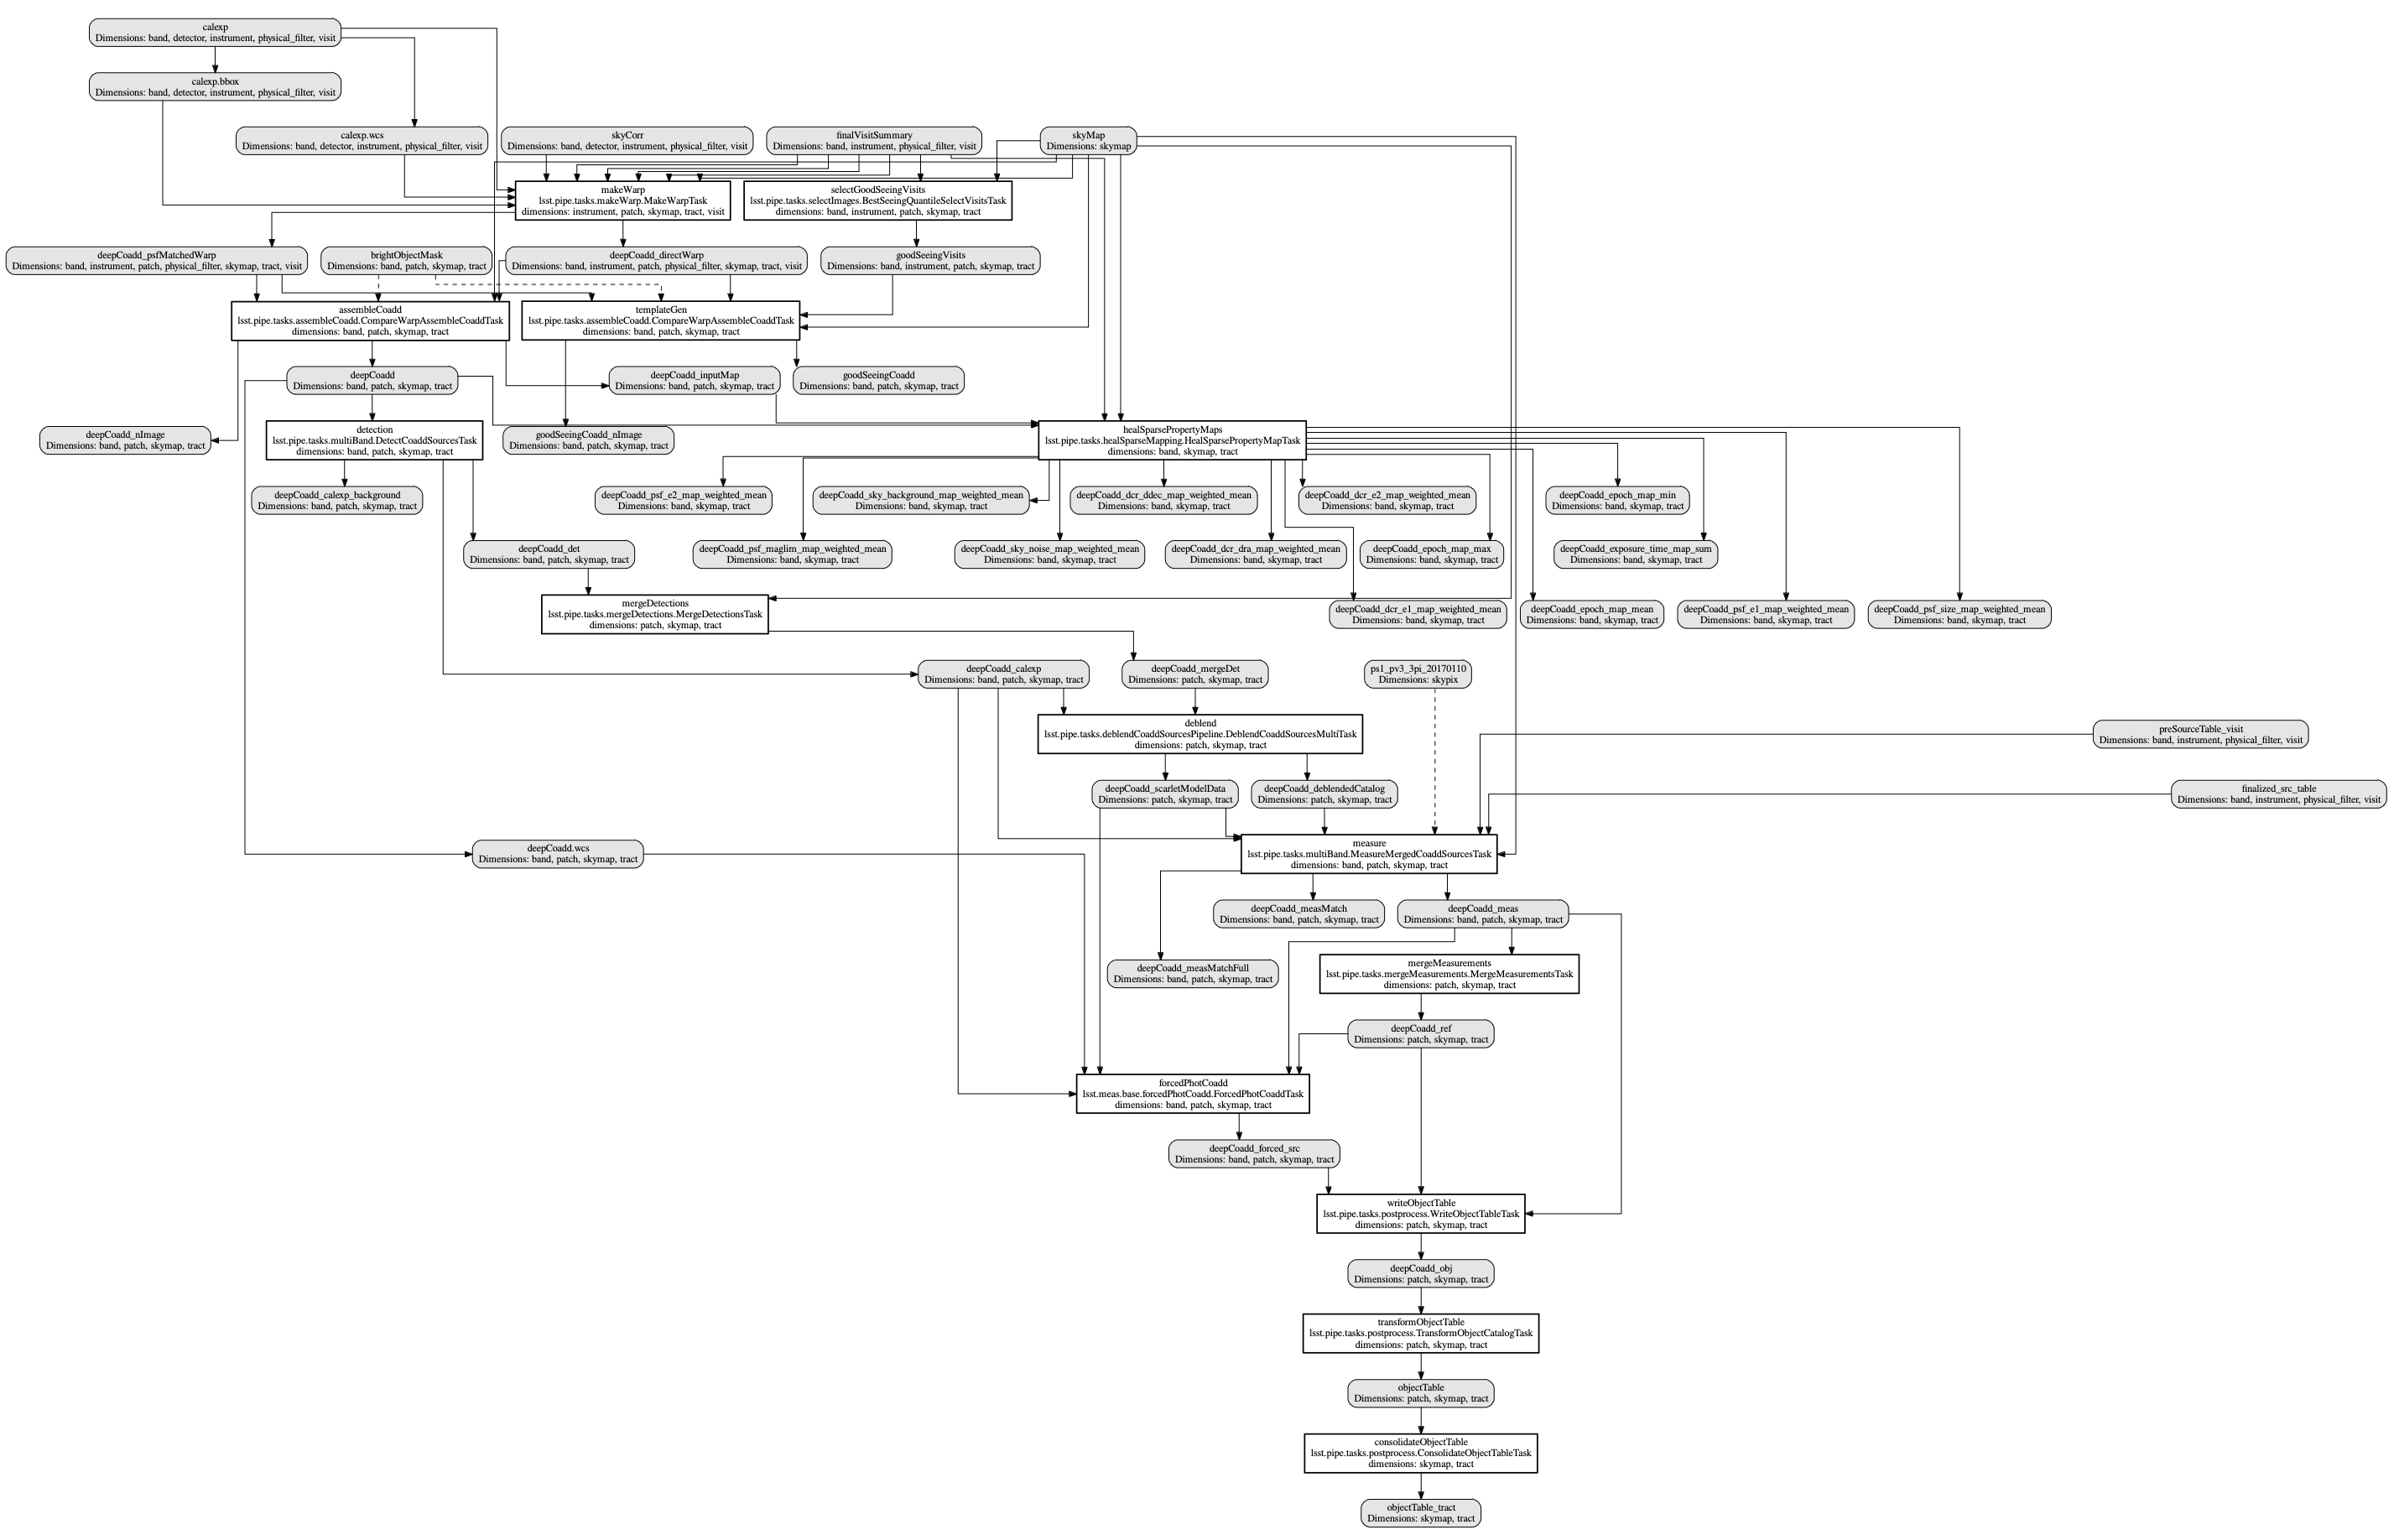

</div>

Here is the complete RC2 processing pipeline, as of the date of this presentation. The graph is always growing or changing as developers add a or modify the software processing pipelines.
<div style="width: 1000px;">

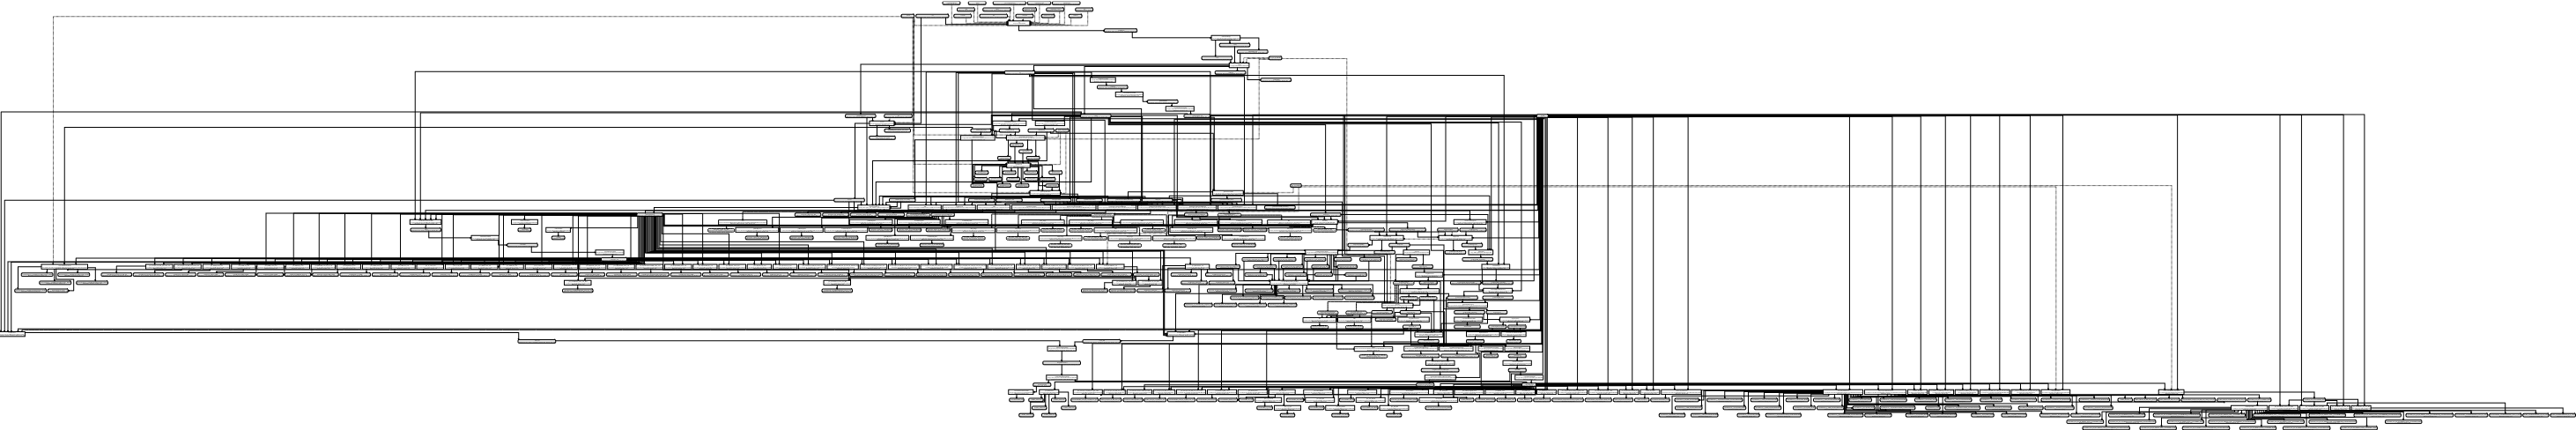

</div>

### Common Pipelines
Many of the pipelines run by DM routinely are found in the packages:
* drp_pipe - Data release processing pipelines
* ap_pipe - Alert production pipelines
* cp_pipe - Calibration production pipelines

### Running Pipelines
Pipelines are run with the `pipetask` command:
```shell
pipetask run -b butler_repo -i input/collection -o output/collection -p path/to/pipeline.yaml
```

If this is the first time a `pipeline` has been run, or if a new `PipelineTask` has been added, you man need to add `--register-dataset-types`. This lets the `Butler` know that the new `DatasetTypes` it sees are not typos and are intended to be new types.

* `butler_repo` - This is the same conceptually as the `Butler` repo we were using above.
* `input/collection` - This is the collection that input data to your pipeline will come from. This may be something low level, like a collection of raws, or it may be another users collection of already processed data.
* `output/collection` - This is the collection your outputs will be placed in.
* `path/to/pipeline.yaml` - This is the pipeline you want to run.

Pipelines do not need to be run in their entirety. Pipelines define labeled subsets of tasks to make it easier to run specific groups of tasks. It is also possible to directly list the tasks to run using their labels. It is permissable to mix a list of labels and subsets when deciding what to run. The syntax for specifying labels is:
```
path/to/pipeline.yaml#label1,label2,subset1
```